In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
%matplotlib inline

# Flow Over a Cylinder with Source Panels

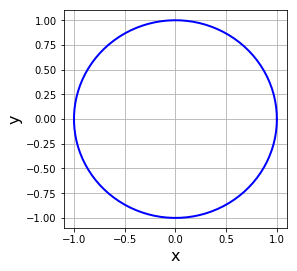

In [2]:
R = 1.0 #radius of cylinder
x_center,y_center = 0.0, 0.0
theta = np.linspace(0.,2*np.pi,100)
x_cylinder,y_cylinder = x_center + R*np.cos(theta),y_center + R*np.sin(theta)

size = 4
plt.figure(figsize=(size, size))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

In [6]:
class Panel:
    
    def __init__(self,xa,ya,xb,yb):
        
        self.xa, self.ya = xa,ya
        self.xb, self.yb = xb,yb
        
        self.xc, self.yc = (xa+xb)/2,(ya+yb)/2
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

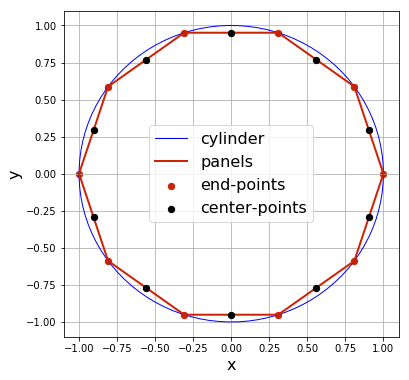

In [11]:
N_panels = 10

x_ends = R * np.cos(np.linspace(0.0,2*np.pi,N_panels+1))
y_ends = R * np.sin(np.linspace(0.0,2*np.pi,N_panels+1))

panels = np.empty(N_panels,dtype=object)

for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

# plot the panels
size = 6
plt.figure(figsize=(size, size))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder,label='cylinder',color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends,label='panels',color='#CD2305', linestyle='-', linewidth=2)
plt.scatter([p.xa for p in panels], [p.ya for p in panels],label='end-points',color='#CD2305', s=40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels],label='center-points',color='k', s=40, zorder=3)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

$$0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial n_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial n_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

where $\beta_i$ is the angle that the panel's normal makes with the $x$-axis, so

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{and}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

and

$$x_j(s_j) = x_{a_j} - \sin\left(\beta_j\right) s_j$$
$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

But, there is still a problem to handle when $i=j$. From the previous notebook, we have seen that the stength of the [source sheet](08_Lesson08_sourceSheet.ipynb) should be a specific value so that the streamlines do not penetrate the panel. This helps us determine that the contribution of the $i$-th panel to itself is $\frac{\sigma_i}{2}$.

Finally, the boundary condition at the center point of the $i$-th panel gives

$$0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$


In [13]:
def integral_normal(p_i, p_j):
    def integrand(s):
        return (((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s)) * np.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s)) * np.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [ ]:
u_inf = 1.0

A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.5)

